In [13]:
import pandas as pd
from statsmodels.stats.proportion import proportion_confint
import numpy as np
import scipy

import matplotlib.font_manager as font_manager
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib as mpl
from plots import set_size
import seaborn as sns
import os

# Latex Configuration
fontpath = os.path.expanduser('../LinLibertine_DRah.ttf')
prop = font_manager.FontProperties(fname=fontpath)

params = {
    "axes.titlesize": 16,
    'axes.labelsize': 14,
    'font.size': 14,
    'legend.fontsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'font.family': prop.get_name(),
    'text.usetex': True
}

mpl.rcParams.update(params)

In [14]:
# Helpers
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array([d for d in data if ~np.isnan(d)])
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n - 1)
    return m, h

def get_buckets(seq, buckets):
    last = -1
    cnts = []
    prob = []
    tt = len(seq)
    for b in buckets:
        cnts.append(len([s for s in seq if (s > last) and (s <= b)]))

        prob.append(len([s for s in seq if (s > last) and (s <= b)]) / float(tt))
        last = b
    return cnts, prob

def get_bucketnames(buckets):
    last = -1
    names = []
    for b in buckets:
        if last == -1:
            names.append('[0, {}]'.format(b))
        else:
            names.append('({}, {}]'.format(last, b))
        last = b
    names[-1] = '> {}\n'.format(buckets[-2])
    return names

def get_bucketnames(buckets):
    last = -1
    names = []
    for b in buckets:
        if last == -1:
            names.append('[0, {}]'.format(b))
        else:
            names.append('({}, {}]'.format(last, b))
        last = b
    names[-1] = '> {}\n'.format(buckets[-2])
    return [n.replace("%", "\%") for n in names]

def paint_bar(buckets, a, b, ax, colors, title, bucketnames=None, rotation=0):
    width = 0.45
    N = len(buckets)
    X = np.arange(N)

    n_bins = 20
    ca, ba = get_buckets(a, buckets)
    cb, bb = get_buckets(b, buckets)

    ax.bar(X + 0.05, ba, color=colors['fringe'], label='Problematic', width=width, alpha=0.7, zorder=3)
    ax.bar(X + 0.05 + width, bb, color=colors['others'], label='Random', width=width, alpha=0.7, zorder=3)

    ax.set_xlabel('Number of Videos Produced')
    ax.set_xticks(X + 0.25)
    ax.set_title(title)
    if bucketnames:
        buckets_str = bucketnames
    else:
        buckets_str = get_bucketnames(buckets)
    print(len(buckets) - 1)
    print(scipy.stats.chisquare(ca, f_exp=cb, ddof=len(buckets) - 1))
    print(ba, bb)
    if rotation > 0:
        ax.set_xticklabels(buckets_str, rotation=rotation, ha='right')
    else:
        ax.set_xticklabels(buckets_str)

# Content creation and usage of alternative monetization strategies (Sec 6)

In [15]:
with open('../data/matched_longevity', 'r') as r:
    total = pd.read_csv(r)
with open("../data/channel_video_monetize.csv", "r") as r:
    tt = pd.read_csv(r)
    
total_num = sum(tt['total'])
tt['percentage'] = tt.apply(lambda x: x['total'] / total_num, axis=1)

buckets = [0, 29, 53, 82, 119, 169, 239, 347, 540, 1027, 121676]
buckets_str = ['({}, {}]'.format(buckets[idx - 1], buckets[idx]) for idx in range(1, 11)]

for x in range(3, 1, -1):
    total['videos_{}'.format(x)] = total.apply(lambda xx: xx['videos_{}'.format(x)] -
                                                          xx['videos_{}'.format(x - 1)],
                                               axis=1)

for x in range(12, 1, -1):
    total['videos_after_{}'.format(x)] = total.apply(lambda xx: xx['videos_after_{}'.format(x)] -
                                                                xx['videos_after_{}'.format(x - 1)],
                                                     axis=1)

findfont: Font family ['Linux Libertine Display'] not found. Falling back to DejaVu Sans.


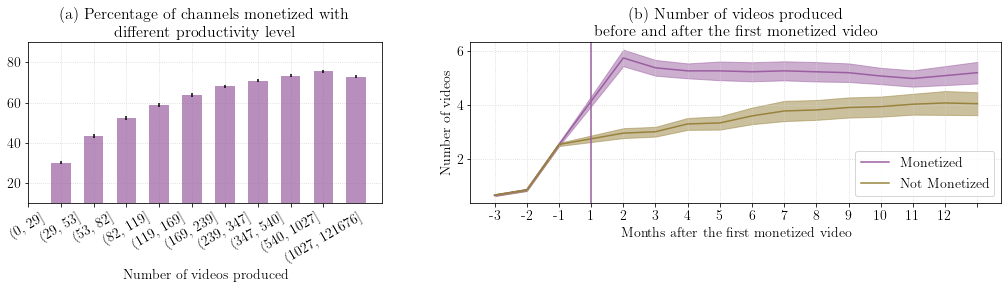

In [16]:
colors = {"monetized": "#9a5ea1",
          "not_monetized": "#98823c"}

fig, axs = plt.subplots(1, 2, figsize=(14, 4), sharex=False, gridspec_kw={'width_ratios': [1, 1.5]})

for ax in axs:
    #ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
    ax.xaxis.grid(color="#d3d3d3", ls=":", zorder=0)
    ax.yaxis.grid(color="#d3d3d3", ls=":", zorder=0)

ax = axs[0]

width = 0.6
error = [proportion_confint(ttt[0], ttt[1]) for ttt in tt[['has_monetization', 'total']].values]
ratios = list(tt['ratio'].values)
p1 = ax.bar(range(1, 11), ratios, width,
            yerr=([ratios[idx] - e[0] for idx, e in enumerate(error)],
                  [e[1] - ratios[idx] for idx, e in enumerate(error)]), color="#9a5ea1", alpha=0.7, zorder=3)

#ax.set_ylabel('Monetized Channels (%)')
ax.set_xlabel('Number of videos produced')
ax.set_ylim(0.1, 0.9)
vals = ax.get_yticks()
#ax.set_ylabel('Percentage of Channels Monetized')
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
ax.set_xticks(range(10))
ax.set_title('(a) Percentage of channels monetized with\ndifferent productivity level')
ax.set_xticklabels(buckets_str, rotation=30)

# Label with label_type 'center' instead of the default 'edge'
ax = axs[1]
matching_interval = 4
xrange = [x for x in range(-matching_interval + 1, 13) if x != 0]
a = [mean_confidence_interval(total[total['has_monetization']]['videos_{}'.format(x)])
     for x in range(matching_interval - 1, 0, -1)] +\
    [mean_confidence_interval(total[total['has_monetization']]['videos_after_{}'.format(x)])
     for x in range(1, 13)]
b = [mean_confidence_interval(total[total['no_monetization']]['videos_{}'.format(x)])
     for x in range(matching_interval - 1, 0, -1)] +\
    [mean_confidence_interval(total[total['no_monetization']]['videos_after_{}'.format(x)].values)
        for x in range(1, 13)]
ax.plot(xrange, [aa[0] for aa in a], label='Monetized', color=colors['monetized'])
ax.fill_between(xrange, [aa[0] - aa[1] for aa in a],
                [aa[0] + aa[1] for aa in a],
                color=colors['monetized'], alpha=0.5)
ax.plot(xrange, [aa[0] for aa in b], label='Not Monetized', color=colors['not_monetized'])
ax.fill_between(xrange, [aa[0] - aa[1] for aa in b],
                [aa[0] + aa[1] for aa in b],
                color=colors['not_monetized'], alpha=0.5)
ax.axvline(x=0, color="#9a5ea1")
ax.set_xticks(range(-3, 13))
ax.set_xlabel('Months after the first monetized video')
ax.set_ylabel('Number of videos')
ax.set_title('(b) Number of videos produced\nbefore and after the first monetized video')
ax.legend(loc="lower right")

ax.set_xticklabels(xrange)
set_size(fig, (14, 4))

plt.savefig('../figs/longevity.pdf', bbox_inches="tight")

# Alternative monetization and problematic content creation (Sec 7)

In [17]:
with open("../data/problematic_content", "r") as r:
    total = pd.read_csv(r)

MannwhitneyuResult(statistic=9.0, pvalue=0.2654346519842541)
[(0.6786703601108033, 0.04817251547924173, 0.04817251547924173), (0.47645429362880887, 0.051520778136248724, 0.05152077813624867), (0.11080332409972299, 0.032379474790758894, 0.032379474790758894), (0.1745152354570637, 0.039153058647977135, 0.039153058647977135), (0.5263157894736842, 0.051506512379880465, 0.051506512379880465)]
[(0.5623268698060941, 0.051175706926546605, 0.051175706926546605), (0.27977839335180055, 0.046305720818315715, 0.04630572081831574), (0.01662049861495845, 0.013187943864922698, 0.013187943864922697), (0.10803324099722991, 0.032021931747706706, 0.032021931747706706), (0.4792243767313019, 0.051533455493265434, 0.05153345549326549)]
MannwhitneyuResult(statistic=53486.5, pvalue=9.14628224616665e-06)
3
Power_divergenceResult(statistic=57.527689978623684, pvalue=nan)
[0.32132963988919666, 0.11357340720221606, 0.24376731301939059, 0.32132963988919666] [0.4376731301939058, 0.10803324099722991, 0.27977839335180

/Users/horta/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


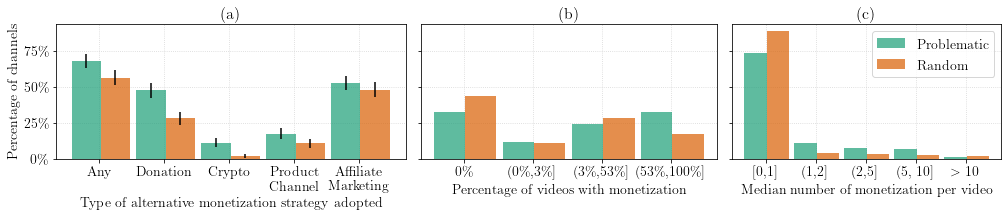

In [18]:
colors = {"fringe": "#1b9e77",
          "others": "#d95f02"}

fig, axs = plt.subplots(1, 3, figsize=(14, 3), sharey=True,
                        gridspec_kw={'width_ratios': [1.3, 1.1, 1],
                                     'wspace': 0.05})

ax = axs[0]

totallen = len(total) / 2.
a = []
b = []

a.append(float(len(total[(total['alt_category'] != 'None')
                         & (total['monetized_percentage'] > 0.)])))
b.append(float(len(total[(total['alt_category'] == 'None')
                         & (total['monetized_percentage'] > 0.)])))  # / totallen)

for e in ['donation', 'crypto', 'merch_channel', 'merch_others']:
    a.append(float(len(total[(total['alt_category'] != 'None')
                             & (total['videos_with_{}'.format(e)] > 0)])))  # / totallen)
    b.append(float(len(total[(total['alt_category'] == 'None')
                             & (total['videos_with_{}'.format(e)] > 0)])))  # / totallen)
print(scipy.stats.mannwhitneyu(a, b))

ya = [(aa / totallen, aa / totallen - proportion_confint(aa, totallen)[0],
       proportion_confint(aa, totallen)[1] - aa / totallen) for aa in a]
yb = [(aa / totallen, aa / totallen - proportion_confint(aa, totallen)[0],
       proportion_confint(aa, totallen)[1] - aa / totallen) for aa in b]

width = 0.45
N = 5
X = np.arange(N)

print(ya)
print(yb)
ax.bar(X + 0.05, [aa[0] for aa in ya], color=colors['fringe'],
       label='Problematic', yerr=([aa[1] for aa in ya], [aa[2] for aa in ya]),
       width=width, alpha=0.7, zorder=3)
ax.bar(X + 0.05 + width, [aa[0] for aa in yb], color=colors['others'],
       label='Random', yerr=([aa[1] for aa in yb], [aa[2] for aa in yb]),
       width=width, alpha=0.7, zorder=3)

#ax.set_xlabel('Number of Videos Produced')
ax.set_xticks(X + 0.25)
#ax.set_title(title)
buckets_str = ['Any', 'Donation', 'Crypto', 'Product\nChannel', 'Affiliate\nMarketing']

#print(scipy.stats.chisquare(ca, f_exp=cb, ddof=len(buckets)-1))
ax.set_xticklabels(buckets_str)  #, rotation=30)

ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
ax.xaxis.grid(color="#d3d3d3", ls=":", zorder=0)
ax.yaxis.grid(color="#d3d3d3", ls=":", zorder=0)

ax = axs[1]
a = total[total['alt_category'] != 'None']['monetized_percentage'].values
b = total[total['alt_category'] == 'None']['monetized_percentage'].values
buckets = [0.0, 0.03, 0.53, 1.0]

print(scipy.stats.mannwhitneyu(a, b))
bucketnames = ['0\%', '(0\%,3\%]', '(3\%,53\%]', '(53\%,100\%]']
paint_bar(buckets, a, b, ax, colors, "(d)", bucketnames, rotation=0)

ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
ax.xaxis.grid(color="#d3d3d3", ls=":", zorder=0)
ax.yaxis.grid(color="#d3d3d3", ls=":", zorder=0)

ax = axs[2]
a = total[total['alt_category'] != 'None']['median_no_monetization'].values
b = total[total['alt_category'] == 'None']['median_no_monetization'].values
print(scipy.stats.mannwhitneyu(a, b))
buckets = [1, 2, 5, 10, max(max(a), max(b))]
bucketnames = ['[0,1]', '(1,2]', '(2,5]', '(5, 10]', '$>$ 10']

paint_bar(buckets, a, b, ax, colors, "(e)", bucketnames, rotation=0)

ax.legend(bbox_to_anchor=(1, 1), loc="upper right", ncol=1)

ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
ax.xaxis.grid(color="#d3d3d3", ls=":", zorder=0)
ax.yaxis.grid(color="#d3d3d3", ls=":", zorder=0)


axs[0].set_title('(a)')
axs[0].set_xlabel('Type of alternative monetization strategy adopted')
axs[0].set_ylabel('Percentage of channels')

axs[1].set_title('(b)')
axs[1].set_xlabel('Percentage of videos with monetization')
axs[2].set_title('(c)')
axs[2].set_xlabel('Median number of monetization per video')
fig.tight_layout(pad=0.02)
set_size(fig, (14, 3))

plt.savefig('../figs/fringe.pdf', bbox_inches="tight")

In [19]:
with open("../data/crypto_total_income.csv", "r") as r:
    cdf = pd.read_csv(r)
with open("../data/patreon_total_income.csv", "r") as r:
    pdf = pd.read_csv(r)

In [20]:
pdf[pdf['money'] > 10000]

,channel_id,money,channel_category,channel_not_avalible_dec_2020
0,UC595wqznMGuY2mi6DKx-qnQ,260562.927229,Manosphere,False
1,UC72vWiZdUN_Y2OC2RgJ-dvA,258552.297602,Alt-lite,False
2,UCcmnLu5cGUGeLy744WS-fsg,244847.394597,Manosphere,False
3,UCcOtHMt1S9Nl4Pycp-FWd8Q,240778.707159,Manosphere,False
4,UCAlVRoYjDbgLx7j6O2N8-2g,237479.161587,Manosphere,False
5,UC6cMYsKMx6XicFcFm7mTsmA,210797.042580,Alt-lite,False
6,UCpiCH7qvGVlzMOqy3dncA5Q,113223.571141,Alt-lite,False
7,UC2h3yPmh9TfQv2z3aTDTHHA,102905.467266,Alt-lite,True
8,UCP9oVEmpxbxmHd1_s3w6wTw,102905.467266,Alt-right,False
9,UCowcNKm1w2GGw5U_XQeduhg,102905.467266,Alt-right,True


In [21]:
buckets = [-1, 0, 100, 1000, 10000, 100000, np.inf]

vals = cdf['value_usd'].values
cnts = [len([v for v in vals if (v > buckets[idx - 1]) and (v <= buckets[idx])])
        for idx in range(1, 7)]

tmp = [-1, 0, 100, '1K', '10K', '100K', np.inf]
bnames = ['({}, {}]'.format(tmp[idx - 1], tmp[idx]) for idx in range(1, 7)]
bnames[0] = '=0'
bnames[-1] = '$>$ 100K'

5540.339735339836
1155.029398749437


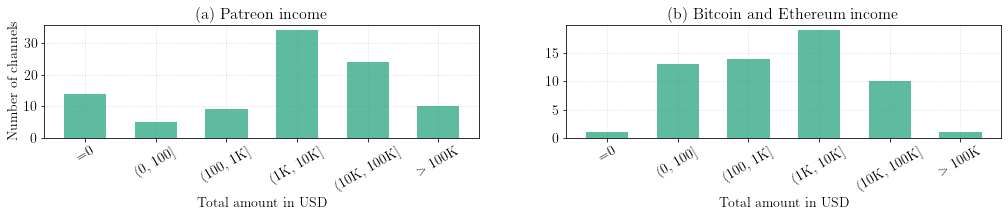

In [22]:
colors = {"monetized": "#1b9e77",
          "not_monetized": "#d95f02"}

fig, axs = plt.subplots(1, 2, figsize=(14, 3), sharex=False, gridspec_kw={'width_ratios': [1, 1]})

ax = axs[0]

width = 0.6
vals = pdf['money'].values
median = np.median(vals)
cnts = [len([v for v in vals if (v > buckets[idx - 1]) and (v <= buckets[idx])])
        for idx in range(1, 7)]
p1 = ax.bar(range(1, 7), cnts, width, color="#1b9e77", alpha=0.7, zorder=3)

#ax.set_ylabel('Monetized Channels (%)')
ax.set_xlabel('Total amount in USD')
ax.set_ylabel('Number of channels')
ax.set_xticks(range(1, 7))
ax.set_title('(a) Patreon income')
ax.set_xticklabels(bnames, rotation=30)
print(median)

ax = axs[1]

width = 0.6
vals = cdf['value_usd'].values
cnts = [len([v for v in vals if (v > buckets[idx - 1]) and (v <= buckets[idx])])
        for idx in range(1, 7)]
p1 = ax.bar(range(1, 7), cnts, width, color="#1b9e77", alpha=0.7, zorder=3)
print(np.median(vals))

#ax.set_ylabel('Monetized Channels (%)')
ax.set_xlabel('Total amount in USD')
ax.set_xticks(range(1, 7))
ax.set_title('(b) Bitcoin and Ethereum income')
ax.set_xticklabels(bnames, rotation=30)

for ax in axs:
    ax.xaxis.grid(color="#d3d3d3", ls=":", zorder=0)
    ax.yaxis.grid(color="#d3d3d3", ls=":", zorder=0)
    
set_size(fig, (14, 3))
plt.savefig('../figs/income.pdf', bbox_inches="tight")